# Making predictions
Predicting artist gender and genre from song lyrics
A follow-up to [*Trucks and Beer*](http://www.johnwmillr.com/trucks-and-beer/), my textual analysis of 12k+ country song lyrics

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import re
from collections import Counter

fs = 16 # fontsize

---
## Load the data

In [3]:
songs = pd.read_json('./data/lyrics/all_songs.json')

In [4]:
artist = songs[songs.artist=='The Beatles']

In [5]:
artist.head()

,album,artist,gender,genre,image,lyrics,raw,title,year
34290,Let It Be,The Beatles,male,rock,https://images.genius.com/1f61e7c20f3ec7d82362...,Words are flowing out like endless rain into a...,"{'annotation_count': 13, 'api_path': '/songs/1...",Across the Universe,1969-12-12
34291,Help!,The Beatles,male,rock,https://images.genius.com/adbf27acc77a06acfa4a...,They're gonna put me in the movies\nThey're go...,"{'annotation_count': 5, 'api_path': '/songs/12...",Act Naturally,1965-08-06
34292,Sgt. Pepper's Lonely Hearts Club Band,The Beatles,male,rock,https://images.genius.com/0e36e5abf5d93b95a6d8...,"I read the news today, oh boy\nAbout a lucky m...","{'annotation_count': 17, 'api_path': '/songs/1...",A Day in the Life,1967-06-01
34293,A Hard Day's Night,The Beatles,male,rock,https://images.genius.com/68c11c7f5b6b66194d77...,It's been a hard day's night\nAnd I've been wo...,"{'annotation_count': 13, 'api_path': '/songs/1...",A Hard Day's Night,1964-07-10
34294,A Hard Day's Night,The Beatles,male,rock,https://images.genius.com/68c11c7f5b6b66194d77...,"Side 11. \t""A Hard Day's Night""\n2. \t""Tell Me...","{'annotation_count': 0, 'api_path': '/songs/14...",A Hard Day's Night (U.S. version),None


## Explore the data

At the start of any analysis, it's helpful to visualize the data and get a rough sense for how they behave.

For textual analyses, a few common metrics are `words_per_sample` and `word_frequency_distributions`

In [6]:
genres = songs.genre.unique()
print(genres)

['rap' 'rock' 'country']


In [7]:
import nltk
from nltk.corpus import stopwords
from string import punctuation
punctuation = "".join([symbol for symbol in punctuation if symbol not in ["'", '"']])

# We'll use these helper functions throughout the analysis
def clean_str(s):
    return s.translate(str.maketrans('', '', punctuation)).replace('\u200b', " ").strip().lower()

def tokenizeText(txt, remove_stop_words=True):
    """Splits a string of text into individual words"""
    stop_words = set(stopwords.words('english')) if remove_stop_words else []
    words = [w for w in clean_str(txt).split() if w not in stop_words]
    return words

### `words_per_song`
In this analysis, each individual song can be considered a 'sample', i.e. `words_per_song` is equivalent to `words_per_sample`

In [8]:
# Calculate words per song (i.e. sample) by genre
def calcNumWordsInText(txt, remove_stop_words=True):
    """Return the number of words in a sample of text"""        
    stop_words = set(stopwords.words('english')) if remove_stop_words else []
    words = tokenizeText(txt)
    return len([w for w in words if w not in stop_words])
        
words_per_song = {}
for genre in genres:    
    words_per_song[genre] = np.array([calcNumWordsInText(s, False) for s in songs[songs.genre==genre].lyrics])

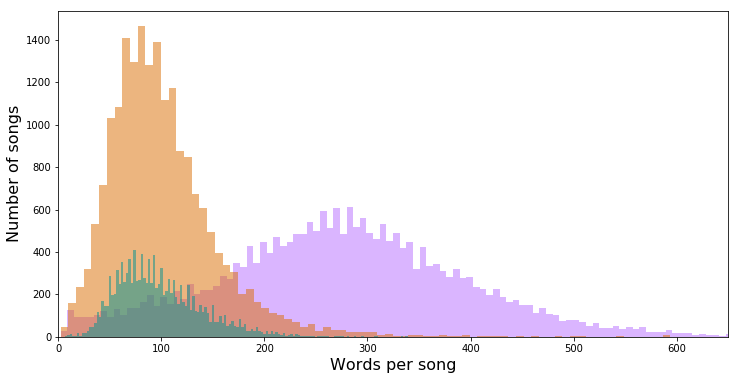

In [27]:
# Words per song by genre
fig, ax = plt.subplots(figsize=(12, 6))
colors = np.array([(182,109,255),(218,109,0),(0,146,146)])/255
for genre, color in zip(genres, colors):
    plt.hist(words_per_song[genre], 1000, color=color, alpha=0.5)
    
ax.set_xlim([0, 650])
ax.set_xlabel("Words per song", fontsize=fs)
ax.set_ylabel("Number of songs", fontsize=fs)
plt.show()

***Class Imbalance***

This histogram also shows us that we have a bit of a class imbalance. There are about 20k song lyrics for rap and rock, but only 12k for country. If the number of samples between classes is too imbalanced when training a model, there's a risk the model will be improperly biased towards predicting certain genres over others. I don't think we have too bad of an imbalance, so I'm hoping we don't need to address the issue now.

However, going forward, it may be helpful to account for this imbalance in our visualizations. One simple step we can use with the `plt.hist` command is to set the `density` option to `True`.

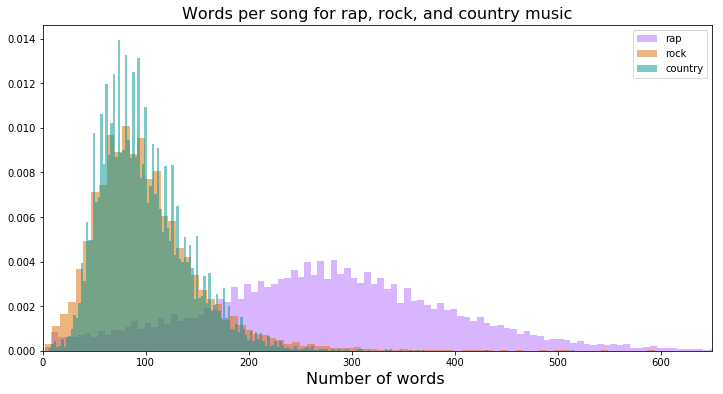

In [28]:
# Words per song by genre
fig, ax = plt.subplots(figsize=(12, 6))
for genre, color in zip(genres, colors):
    plt.hist(words_per_song[genre], 1000, color=color, alpha=0.5, density=True, label=genre)
    
ax.set_xlim([0, 650])
ax.set_xlabel("Number of words ", fontsize=fs)
ax.set_title("Words per song for rap, rock, and country music", fontsize=fs)
ax.legend()
plt.show()

### `word_frequency_distributions`

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
# What are the most popular words for each genre?
def plot_freq_dist(sample_texts,
                   ngram_range=(1, 2),
                  num_ngrams=50,
                  mfeats=None,
                  color='b'):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    https://developers.google.com/machine-learning/guides/text-classification/step-2
    """
    
    # TEMPORARY - Shorten the list of texts
#     sample_texts = sample_texts[:1000]
    
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'max_features': mfeats,
            'analyzer': 'word',  # Split text into word tokens.
            'tokenizer': tokenizeText, # Custom tokenizer
    }
    vectorizer = CountVectorizer(**kwargs)
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]
        
    # Make the graph
    idx = np.arange(num_ngrams)
    fig, ax = plt.subplots(figsize=(14,4))
    ax.bar(idx, counts, width=0.8, color=color, alpha=0.5)
    ax.set_ylabel('Frequencies')    
    plt.xticks(idx, ngrams, rotation=45)

Using the (slightly modified) code above taken from a [Google tutorial](https://developers.google.com/machine-learning/guides/text-classification/step-2) on text analysis, we can easily look at the ten most frequent words for each of the three genres.

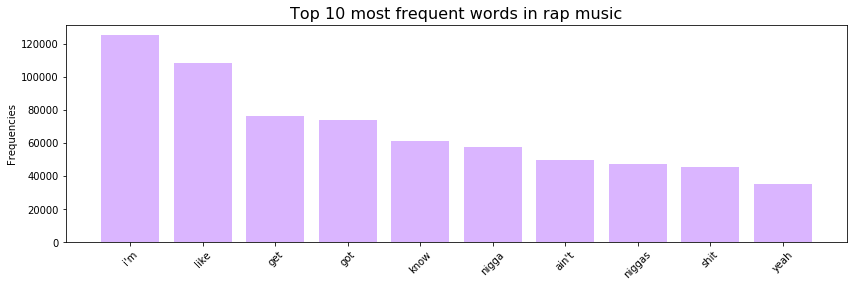

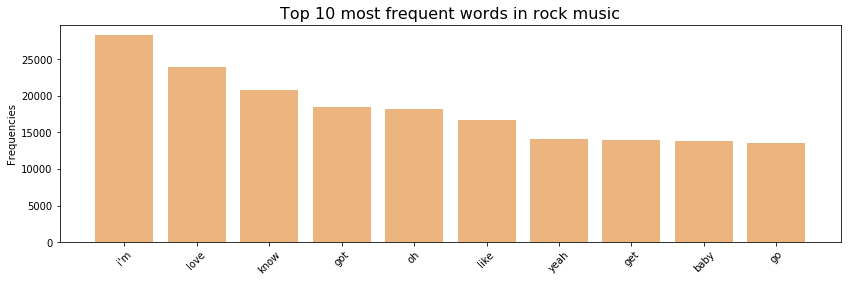

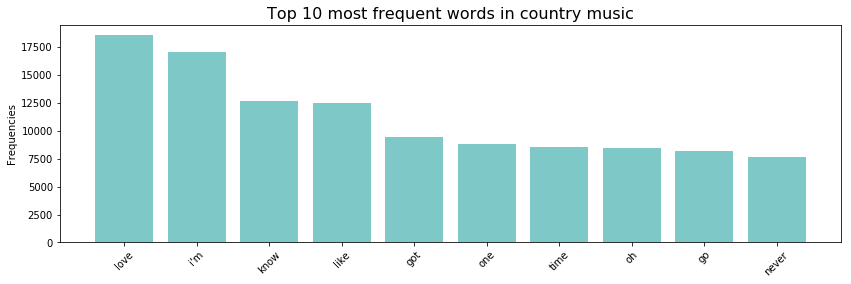

In [24]:
mf = 10
for g, c in zip(genres, colors):
    plot_freq_dist(songs[songs.genre==g].lyrics, color=c, mfeats=mf)
    plt.title(f'Top {mf} most frequent words in {g} music', fontsize=fs)

### Section summary
By making these preliminary visualizations, we begin to get a sense for what features may be useful for differentiating between genres. For example, it looks like `words_per_song` may be helpful for identifying **rap** songs, but won't be all that useful for distinguishing between **rock** and **country** lyrics.

## Data Preparation

### Vectorization
We need to convert the raw text into numbers. We'll do this in two steps:
  1. Tokenization
  2. Encoding

# Review
 - What features are most useful for classifying genre? And for gender?